<h1> Deep Learning Model 4

First score is Private and second score is Public score

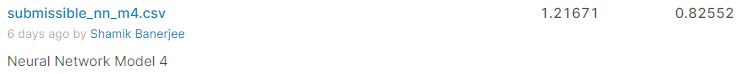

#### Installs and Imports

In [13]:
# !unzip m5-forecasting-accuracy.zip

# !apt-get update
# !apt-get install wget

# ! pip install pandas
# ! pip install calender
# ! pip install numpy
# ! pip install datetime
# ! pip install matplotlib
# ! pip install collections
# ! pip install random
# ! pip install tqdm
# ! pip install sklearn
# ! pip install lightgbm

In [11]:
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.183 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18599/1236839/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1605098805&Signature=mxKXOkRvWTFe4iO0qjeG%2FYaSe60c9c5Rzd4t30F0ppuxk0%2FfjymTXorLhuRBOWi60l3%2F1AFhnLBXlU1%2BL5wLP6Tf0Lv9MWnpg2WZ00Ugfz19v91Orp1CpnbFmkNo0fh04R4rA%2Fd7%2FOJ6%2Bc6qLPQDdCnbvWSxlMpSerZ0Hx5U9suwh%2FBXuZSjiTeGggdNmeAO0tsIRAz%2BBQ1jE1KQEkCLwfXVr%2BaMPh%2Bi57Q5FiPS6OfdhoO%2BP1a2%2FFdDarIzKe8Ga6Ay2vTjHGzPsDJ7wdmtIpxVyaIcy0iSnkGJJ30ok0JowHFZ50NOqZcf3atRKJJiG%2FKulIObtnL6HLRjc%2B4X2Q%3D%3D&response-content-disposition=attachment%3B+filename%3Dm5-forecasting-accuracy.zip" -c -O 'm5-forecasting-accuracy.zip'

In [20]:
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import activations
from IPython.display import clear_output as cclear
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import ModelCheckpoint

#### Functions

In [21]:
class terminate_on_acc(tf.keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        loss = logs['loss']
        if loss < target_loss:
            self.model.stop_training = True
terminate_on_acc = terminate_on_acc()

n_steps_in, n_steps_out = 365, 28              # input is 1885 days, output 28 days
n_features = 1

In [ ]:
# eval 0---------1885-----1913-----1941------1969
#          1548-----------1913-----1941------1969
#          -------xtrain---.--ytrain---
#              (1548-1913)  (1913-1941)
#            ------------xtest---------
#                     (1520-1941)
            
# val  0---------1885-----1913
#            1548-----------1913
#            xtrain-----.ytrain-
#   (1548 to (1913-28))   ((1913-28) to 1913)
#            -------xtest-------
#           ((1913-365) to 1913)

In [ ]:
def train_NN(df, dept_id, epoch_no, model):    
    
    dept_df = df[df.dept_id == dept_id]
    print('Working on Dept ', dept_id, 'Total rows to process ', len(dept_df))
    
    id_col = list(dept_df['id'])                                     # we preserve the id_col to recreate the output later
    dept_df = dept_df.drop(['id','item_id','dept_id','cat_id','store_id','state_id'], 1)

    
    if df.id.iloc[0].find('evaluation') != -1:                       # if evaluation data
        xtr_from, xtr_to, ytr_to = 1913-365, 1913, 1941                    
        xte_from, xte_to = 1941-365, 1941                                  
        checkpoint = ModelCheckpoint(filepath='model_'+str(dept_id)+'_m4_ev.h5',
                                     monitor='loss', verbose=1, save_best_only=True, mode='auto')
    if df.id.iloc[0].find('validation') != -1:                       # if validation data
        xtr_from, xtr_to, ytr_to = 1913-365, 1913-28, 1913                 
        xte_from, xte_to = 1913-365, 1913                                  
        checkpoint = ModelCheckpoint(filepath='model_'+str(dept_id)+'_m4_val.h5',
                                     monitor='loss', verbose=1, save_best_only=True, mode='auto')
    
    
    X_train, y_train = dept_df.iloc[:, xtr_from:xtr_to], dept_df.iloc[:, xtr_to:ytr_to]
    X_test = dept_df.iloc[:, xte_from:xte_to]    
    
    X_train, y_train, X_test = np.matrix(X_train).astype(np.float32), np.matrix(y_train).astype(np.float32),\
                               np.matrix(X_test).astype(np.float32)
    
    X_train, y_train = tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)
    X_test = tf.convert_to_tensor(X_test)
    
    X_train = tf.reshape(X_train, shape = (X_train.shape[0], X_train.shape[1], n_features))
    y_train = tf.reshape(y_train, shape = (y_train.shape[0], y_train.shape[1], n_features))
    X_test = tf.reshape(X_train, shape = (X_train.shape[0], X_train.shape[1], n_features))
    
    
    
    model.fit(X_train, y_train, epochs=epoch_no, verbose=1, callbacks = [terminate_on_acc, checkpoint])
    
    print('Predicting...')
    y_hat = model.predict(X_test)
    
    out_df = pd.DataFrame(y_hat)
    l = []                                              # In this part we rename the columns to F_1, F_2 ....
    for i in range(1,29):
        l.append('F'+str(i))
    out_df.columns = l
    out_df['id'] = id_col
    
    cols = list(out_df)                                           
    cols = [cols[-1]] + cols[:-1]
    out_df = out_df[cols]
    
    print('Writing output...')
    print('Done.')
    return out_df

#### Training for Evaluation Data

In [23]:
df = pd.read_csv('sales_train_evaluation.csv')
dept_list = list(set(df.dept_id))
dept_list

['HOBBIES_1',
 'HOUSEHOLD_1',
 'HOBBIES_2',
 'FOODS_2',
 'FOODS_1',
 'FOODS_3',
 'HOUSEHOLD_2']

In [ ]:
target_loss = 4    

model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [29]:
dept_name_to_train = 'HOBBIES_1'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_ev.csv', index=False)

Working on Dept  HOBBIES_1 Total rows to process  4160
Train on 4160 samples
Epoch 1/10
4128/4160 [============================>.] - ETA: 0s - loss: 5.7405
Epoch 00001: loss improved from inf to 5.70960, saving model to model_HOBBIES_1_ev.h5
4160/4160 [==============================] - 74s 18ms/sample - loss: 5.7096
Epoch 2/10
4128/4160 [============================>.] - ETA: 0s - loss: 5.7875
Epoch 00002: loss did not improve from 5.70960
4160/4160 [==============================] - 72s 17ms/sample - loss: 5.7978
Epoch 3/10
4128/4160 [============================>.] - ETA: 0s - loss: 5.2912
Epoch 00003: loss improved from 5.70960 to 5.26808, saving model to model_HOBBIES_1_ev.h5
4160/4160 [==============================] - 73s 18ms/sample - loss: 5.2681
Epoch 4/10
4128/4160 [============================>.] - ETA: 0s - loss: 5.2787
Epoch 00004: loss improved from 5.26808 to 5.26386, saving model to model_HOBBIES_1_ev.h5
4160/4160 [==============================] - 72s 17ms/sample - los

In [30]:
dept_name_to_train = 'HOBBIES_2'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_ev.csv', index=False)

Working on Dept  HOBBIES_2 Total rows to process  1490
Train on 1490 samples
Epoch 1/10
1472/1490 [============================>.] - ETA: 0s - loss: 0.8943
Epoch 00001: loss improved from inf to 0.89034, saving model to model_HOBBIES_2_ev.h5
1490/1490 [==============================] - 29s 19ms/sample - loss: 0.8903
Predicting...
Writing output...
Done.


In [31]:
dept_name_to_train = 'FOODS_1'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_ev.csv', index=False)

Working on Dept  FOODS_1 Total rows to process  2160
Train on 2160 samples
Epoch 1/10
2144/2160 [============================>.] - ETA: 0s - loss: 12.5742
Epoch 00001: loss improved from inf to 12.50411, saving model to model_FOODS_1_ev.h5
2160/2160 [==============================] - 39s 18ms/sample - loss: 12.5041
Epoch 2/10
2144/2160 [============================>.] - ETA: 0s - loss: 11.9722
Epoch 00002: loss improved from 12.50411 to 11.91743, saving model to model_FOODS_1_ev.h5
2160/2160 [==============================] - 39s 18ms/sample - loss: 11.9174
Epoch 3/10
2144/2160 [============================>.] - ETA: 0s - loss: 11.8707
Epoch 00003: loss did not improve from 11.91743
2160/2160 [==============================] - 39s 18ms/sample - loss: 11.9190
Epoch 4/10
2144/2160 [============================>.] - ETA: 0s - loss: 11.9844
Epoch 00004: loss improved from 11.91743 to 11.91687, saving model to model_FOODS_1_ev.h5
2160/2160 [==============================] - 39s 18ms/sample 

In [32]:
dept_name_to_train = 'FOODS_2'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_ev.csv', index=False)

Working on Dept  FOODS_2 Total rows to process  3980
Train on 3980 samples
Epoch 1/10
3968/3980 [============================>.] - ETA: 0s - loss: 8.6081
Epoch 00001: loss improved from inf to 8.63587, saving model to model_FOODS_2_ev.h5
3980/3980 [==============================] - 71s 18ms/sample - loss: 8.6359
Epoch 2/10
3968/3980 [============================>.] - ETA: 0s - loss: 8.6391
Epoch 00002: loss improved from 8.63587 to 8.61806, saving model to model_FOODS_2_ev.h5
3980/3980 [==============================] - 71s 18ms/sample - loss: 8.6181
Epoch 3/10
3968/3980 [============================>.] - ETA: 0s - loss: 8.6353
Epoch 00003: loss did not improve from 8.61806
3980/3980 [==============================] - 71s 18ms/sample - loss: 8.6194
Epoch 4/10
3968/3980 [============================>.] - ETA: 0s - loss: 8.6327
Epoch 00004: loss improved from 8.61806 to 8.61600, saving model to model_FOODS_2_ev.h5
3980/3980 [==============================] - 71s 18ms/sample - loss: 8.616

In [ ]:
# It is possible FOODS_3 needs the data to be broken to years, may be the model is unable to learn all the years
# together. We try to break it in Model 5. For now we will use this MSE.

In [33]:
dept_name_to_train = 'FOODS_3'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_ev.csv', index=False)

Working on Dept  FOODS_3 Total rows to process  8230
Train on 8230 samples
Epoch 1/10
8224/8230 [============================>.] - ETA: 0s - loss: 31.4986
Epoch 00001: loss improved from inf to 31.47969, saving model to model_FOODS_3_ev.h5
8230/8230 [==============================] - 147s 18ms/sample - loss: 31.4797
Epoch 2/10
8224/8230 [============================>.] - ETA: 0s - loss: 31.4326
Epoch 00002: loss improved from 31.47969 to 31.41348, saving model to model_FOODS_3_ev.h5
8230/8230 [==============================] - 147s 18ms/sample - loss: 31.4135
Epoch 3/10
8224/8230 [============================>.] - ETA: 0s - loss: 31.4286
Epoch 00003: loss improved from 31.41348 to 31.40882, saving model to model_FOODS_3_ev.h5
8230/8230 [==============================] - 147s 18ms/sample - loss: 31.4088
Epoch 4/10
8224/8230 [============================>.] - ETA: 0s - loss: 31.4505
Epoch 00004: loss did not improve from 31.40882
8230/8230 [==============================] - 147s 18ms/sam

In [34]:
dept_name_to_train = 'HOUSEHOLD_1'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_ev.csv', index=False)

Working on Dept  HOUSEHOLD_1 Total rows to process  5320
Train on 5320 samples
Epoch 1/10
5312/5320 [============================>.] - ETA: 0s - loss: 7.3126
Epoch 00001: loss improved from inf to 7.32039, saving model to model_HOUSEHOLD_1_ev.h5
5320/5320 [==============================] - 95s 18ms/sample - loss: 7.3204
Epoch 2/10
5312/5320 [============================>.] - ETA: 0s - loss: 7.2427
Epoch 00002: loss improved from 7.32039 to 7.23633, saving model to model_HOUSEHOLD_1_ev.h5
5320/5320 [==============================] - 95s 18ms/sample - loss: 7.2363
Epoch 3/10
5312/5320 [============================>.] - ETA: 0s - loss: 7.2436
Epoch 00003: loss did not improve from 7.23633
5320/5320 [==============================] - 96s 18ms/sample - loss: 7.2381
Epoch 4/10
5312/5320 [============================>.] - ETA: 0s - loss: 7.2439
Epoch 00004: loss did not improve from 7.23633
5320/5320 [==============================] - 95s 18ms/sample - loss: 7.2377
Epoch 5/10
5312/5320 [=====

In [35]:
dept_name_to_train = 'HOUSEHOLD_2'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_ev.csv', index=False)

Working on Dept  HOUSEHOLD_2 Total rows to process  5150
Train on 5150 samples
Epoch 1/10
5120/5150 [============================>.] - ETA: 0s - loss: 1.1632
Epoch 00001: loss improved from inf to 1.15916, saving model to model_HOUSEHOLD_2_ev.h5
5150/5150 [==============================] - 92s 18ms/sample - loss: 1.1592
Predicting...
Writing output...
Done.


#### Training for Validation Data

In [37]:
df = pd.read_csv('sales_train_validation.csv')
dept_list = list(set(df.dept_id))
dept_list

['HOBBIES_1',
 'HOUSEHOLD_1',
 'HOBBIES_2',
 'FOODS_2',
 'FOODS_1',
 'FOODS_3',
 'HOUSEHOLD_2']

In [42]:
target_loss = 4 
n_steps_in, n_steps_out = 337, 28   

model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [43]:
dept_name_to_train = 'HOBBIES_1'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_val.csv', index=False)

Working on Dept  HOBBIES_1 Total rows to process  4160
Train on 4160 samples
Epoch 1/10
4128/4160 [============================>.] - ETA: 0s - loss: 4.8566
Epoch 00001: loss improved from inf to 4.86622, saving model to model_HOBBIES_1_val.h5
4160/4160 [==============================] - 69s 17ms/sample - loss: 4.8662
Epoch 2/10
4128/4160 [============================>.] - ETA: 0s - loss: 3.8923
Epoch 00002: loss improved from 4.86622 to 3.87189, saving model to model_HOBBIES_1_val.h5
4160/4160 [==============================] - 66s 16ms/sample - loss: 3.8719
Predicting...
Writing output...
Done.


In [44]:
dept_name_to_train = 'HOBBIES_2'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_val.csv', index=False)

Working on Dept  HOBBIES_2 Total rows to process  1490
Train on 1490 samples
Epoch 1/10
1472/1490 [============================>.] - ETA: 0s - loss: 0.6285
Epoch 00001: loss improved from inf to 0.62627, saving model to model_HOBBIES_2_val.h5
1490/1490 [==============================] - 26s 18ms/sample - loss: 0.6263
Predicting...
Writing output...
Done.


In [45]:
dept_name_to_train = 'FOODS_1'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_val.csv', index=False)

Working on Dept  FOODS_1 Total rows to process  2160
Train on 2160 samples
Epoch 1/10
2144/2160 [============================>.] - ETA: 0s - loss: 6.3352
Epoch 00001: loss improved from inf to 6.33056, saving model to model_FOODS_1_val.h5
2160/2160 [==============================] - 36s 17ms/sample - loss: 6.3306
Epoch 2/10
2144/2160 [============================>.] - ETA: 0s - loss: 5.6592
Epoch 00002: loss improved from 6.33056 to 5.65905, saving model to model_FOODS_1_val.h5
2160/2160 [==============================] - 36s 17ms/sample - loss: 5.6591
Epoch 3/10
2144/2160 [============================>.] - ETA: 0s - loss: 5.4389
Epoch 00003: loss improved from 5.65905 to 5.42793, saving model to model_FOODS_1_val.h5
2160/2160 [==============================] - 36s 17ms/sample - loss: 5.4279
Epoch 4/10
2144/2160 [============================>.] - ETA: 0s - loss: 5.1686
Epoch 00004: loss improved from 5.42793 to 5.17323, saving model to model_FOODS_1_val.h5
2160/2160 [==================

In [46]:
dept_name_to_train = 'FOODS_2'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_val.csv', index=False)

Working on Dept  FOODS_2 Total rows to process  3980
Train on 3980 samples
Epoch 1/10
3968/3980 [============================>.] - ETA: 0s - loss: 4.1481
Epoch 00001: loss improved from inf to 4.13970, saving model to model_FOODS_2_val.h5
3980/3980 [==============================] - 67s 17ms/sample - loss: 4.1397
Epoch 2/10
3968/3980 [============================>.] - ETA: 0s - loss: 3.7234
Epoch 00002: loss improved from 4.13970 to 3.72195, saving model to model_FOODS_2_val.h5
3980/3980 [==============================] - 66s 17ms/sample - loss: 3.7220
Predicting...
Writing output...
Done.


In [50]:
target_loss = 7
dept_name_to_train = 'FOODS_3'

out_df = train_NN(df, dept_name_to_train, 25, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_val.csv', index=False)

Working on Dept  FOODS_3 Total rows to process  8230
Train on 8230 samples
Epoch 1/25
8224/8230 [============================>.] - ETA: 0s - loss: 10.1643
Epoch 00001: loss improved from inf to 10.15839, saving model to model_FOODS_3_val.h5
8230/8230 [==============================] - 137s 17ms/sample - loss: 10.1584
Epoch 2/25
8224/8230 [============================>.] - ETA: 0s - loss: 12.8190
Epoch 00002: loss did not improve from 10.15839
8230/8230 [==============================] - 138s 17ms/sample - loss: 12.8124
Epoch 3/25
8224/8230 [============================>.] - ETA: 0s - loss: 11.3975
Epoch 00003: loss did not improve from 10.15839
8230/8230 [==============================] - 136s 17ms/sample - loss: 11.3927
Epoch 4/25
8224/8230 [============================>.] - ETA: 0s - loss: 10.8027
Epoch 00004: loss did not improve from 10.15839
8230/8230 [==============================] - 138s 17ms/sample - loss: 10.8075
Epoch 5/25
8224/8230 [============================>.] - ETA: 0s

In [48]:
dept_name_to_train = 'HOUSEHOLD_1'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_val.csv', index=False)

Working on Dept  HOUSEHOLD_1 Total rows to process  5320
Train on 5320 samples
Epoch 1/10
5312/5320 [============================>.] - ETA: 0s - loss: 3.8341
Epoch 00001: loss improved from inf to 3.83166, saving model to model_HOUSEHOLD_1_val.h5
5320/5320 [==============================] - 89s 17ms/sample - loss: 3.8317
Predicting...
Writing output...
Done.


In [49]:
dept_name_to_train = 'HOUSEHOLD_2'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_m4_val.csv', index=False)

Working on Dept  HOUSEHOLD_2 Total rows to process  5150
Train on 5150 samples
Epoch 1/10
5120/5150 [============================>.] - ETA: 0s - loss: 0.6495
Epoch 00001: loss improved from inf to 0.64920, saving model to model_HOUSEHOLD_2_val.h5
5150/5150 [==============================] - 85s 17ms/sample - loss: 0.6492
Predicting...
Writing output...
Done.


#### Merging outputs for all departments

In [51]:
def fun(name):
    return pd.read_csv(name+'.csv')

food1ev, food2ev, food3ev = fun('FOODS_1_m4_ev'), fun('FOODS_2_m4_ev'), fun('FOODS_3_m4_ev')
hobbies1ev, hobbies2ev = fun('HOBBIES_1_m4_ev'), fun('HOBBIES_2_m4_ev')
house1ev, house2ev = fun('HOUSEHOLD_1_m4_ev'), fun('HOUSEHOLD_2_m4_ev')

food1val, food2val, food3val = fun('FOODS_1_m4_val'), fun('FOODS_2_m4_val'), fun('FOODS_3_m4_val')
hobbies1val, hobbies2val = fun('HOBBIES_1_m4_val'), fun('HOBBIES_2_m4_val')
house1val, house2val = fun('HOUSEHOLD_1_m4_val'), fun('HOUSEHOLD_2_m4_val')

In [52]:
main_out_df_ev = pd.concat([food1ev, food2ev, food3ev, hobbies1ev, hobbies2ev, house1ev, house2ev], 
                           ignore_index=False)
main_out_df_val = pd.concat([food1val, food2val, food3val, hobbies1val, hobbies2val, house1val, house2val],
                            ignore_index=False)

In [53]:
def reorder(df, main_out):
    df['sp_index'] = (df.index)
    index_dict = dict(zip(df.id, df.sp_index))
    df = df.drop('sp_index', axis=1)
    main_out['sp_index'] = main_out["id"].map(index_dict)
    main_out = main_out.sort_values(by='sp_index', axis=0)
    main_out = main_out.drop('sp_index', axis=1)
    return main_out

In [54]:
out_1 = reorder(pd.read_csv('sales_train_evaluation.csv'), main_out_df_ev)
out_2 = reorder(pd.read_csv('sales_train_validation.csv'), main_out_df_val)

In [55]:
df = pd.concat([out_1, out_2], ignore_index=False)
df.to_csv('submissible_nn_m4.csv')

In [56]:
df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.797639,0.768310,0.783257,0.769936,0.856761,1.100346,1.032933,0.872190,0.927199,...,0.809794,1.046554,1.049505,0.752165,0.740498,0.784890,0.727829,0.891138,1.175545,1.125135
1,HOBBIES_1_002_CA_1_evaluation,0.797639,0.768310,0.783257,0.769936,0.856761,1.100346,1.032933,0.872190,0.927199,...,0.809794,1.046554,1.049505,0.752165,0.740498,0.784890,0.727829,0.891138,1.175545,1.125135
2,HOBBIES_1_003_CA_1_evaluation,0.797639,0.768310,0.783257,0.769936,0.856761,1.100346,1.032933,0.872190,0.927199,...,0.809794,1.046554,1.049505,0.752165,0.740498,0.784890,0.727829,0.891138,1.175545,1.125135
3,HOBBIES_1_004_CA_1_evaluation,0.797639,0.768310,0.783257,0.769936,0.856761,1.100346,1.032933,0.872190,0.927199,...,0.809794,1.046554,1.049505,0.752165,0.740498,0.784890,0.727829,0.891138,1.175545,1.125135
4,HOBBIES_1_005_CA_1_evaluation,0.797639,0.768310,0.783257,0.769936,0.856761,1.100346,1.032933,0.872190,0.927199,...,0.809794,1.046554,1.049505,0.752165,0.740498,0.784890,0.727829,0.891138,1.175545,1.125135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8225,FOODS_3_823_WI_3_validation,0.406299,0.353426,0.304667,0.308852,0.403733,0.400387,0.639327,0.503734,0.434844,...,0.359811,0.379057,0.479020,0.457715,0.423304,0.432291,0.442275,0.420320,0.404418,0.643699
8226,FOODS_3_824_WI_3_validation,0.381522,0.329032,0.280231,0.284648,0.373213,0.362834,0.598375,0.476083,0.405920,...,0.329022,0.343528,0.441265,0.429598,0.397477,0.409173,0.418489,0.392695,0.369446,0.611649
8227,FOODS_3_825_WI_3_validation,0.896857,0.838457,0.790532,0.795795,1.011501,1.147834,1.451020,1.053665,1.008372,...,0.972875,1.086520,1.233734,1.015385,0.939698,0.894035,0.917400,0.972814,1.104909,1.282722
8228,FOODS_3_826_WI_3_validation,1.263219,1.200322,1.153019,1.158073,1.464772,1.705341,2.057056,1.463928,1.436544,...,1.430103,1.614153,1.796083,1.431692,1.324452,1.238158,1.271485,1.384439,1.626607,1.759161


In [57]:
df = df.round(2)
df.to_csv('submissible_nn_m4.csv')